In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

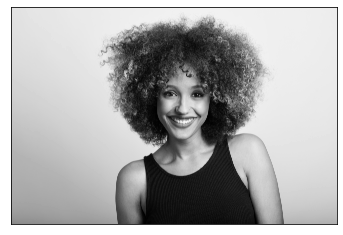

In [4]:
image = cv2.imread('face2.jpg')

training_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

training_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(training_gray, cmap='gray')

plt.xticks([])
plt.yticks([])
plt.show()

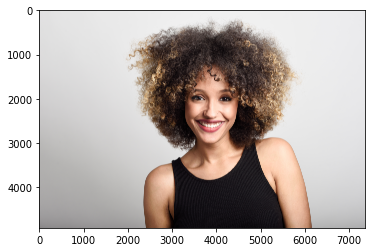

In [5]:
plt.imshow(training_image)

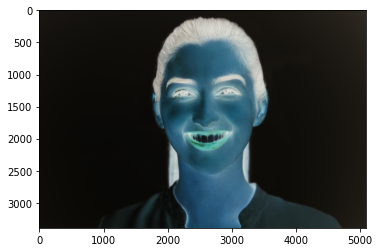

In [6]:
from PIL import Image
import PIL.ImageOps

image = Image.open('face1.jpg')

inverted_image = PIL.ImageOps.invert(image)

plt.imshow(inverted_image)

In [7]:
import numpy as np
gray = cv2.cvtColor(np.array(inverted_image), cv2.COLOR_RGB2GRAY)

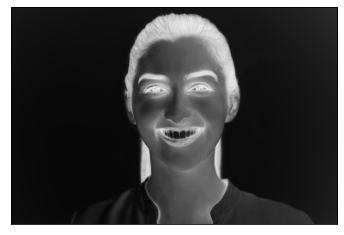

In [8]:
plt.imshow(gray,cmap='gray')

plt.xticks([])
plt.yticks([])
plt.show()

## Locating Keypoints

The first step in the ORB algorithm is to locate all the keypoints in the training image. After the keypoints have been located, ORB creates their corresponding binary feature vectors and groups them together in the ORB descriptor.

We will use OpenCV’s `ORB` class to locate the keypoints and create their corresponding ORB descriptor. The parameters of the ORB algorithm are setup using the `ORB_create()` function. The parameters of the `ORB_create()` function and their default values are given below:


`cv2.ORB_create(nfeatures = 500,
               scaleFactor = 1.2,
		       nlevels = 8,
		       edgeThreshold = 31,
		       firstLevel = 0,
		       WTA_K = 2,
		       scoreType = HARRIS_SCORE,
		       patchSize = 31,
		       fastThreshold = 20)`

Parameters:

* **nfeatures** - *int*
Determines the maximum number of features (keypoints) to locate.


* **scaleFactor** - *float*
Pyramid decimation ratio, must be greater than 1. ORB uses an image pyramid to find features, therefore you must provide the scale factor between each layer in the pyramid and the number of levels the pyramid has. A `scaleFactor = 2` means the classical pyramid, where each next level has 4x less pixels than the previous. A big scale factor will diminish the number of features found.


* **nlevels** - *int*
The number of pyramid levels. The smallest level will have a linear size equal to input_image_linear_size/pow(scaleFactor, nlevels).


* **edgeThreshold** - - *int*
The size of the border where features are not detected. Since the keypoints have a specific pixel size, the edges of images must be excluded from the search. The size of the `edgeThreshold` should be equal to or greater than the patchSize parameter.


* **firstLevel** - *int*
This parameter allows you to determine which level should be treated as the first level in the pyramid. It should be 0 in the current implementation. Usually, the pyramid level with a scale of unity is considered the first level.


* **WTA_K** - *int*
The number of random pixels used to produce each element of the oriented BRIEF descriptor. The possible values are 2, 3, and 4, with 2 being the default value. For example, a value of 3 means three random pixels are chosen at a time to compare their brightness. The index of the brightest pixel is returned. Since there are 3 pixels, the returned index will be either 0, 1, or 2.


* **scoreType** - *int*
This parameter can be set to either HARRIS_SCORE or FAST_SCORE. The default HARRIS_SCORE means that the Harris corner algorithm is used to rank features. The score is used to only retain the best features. The FAST_SCORE produces slightly less stable keypoints, but it is a little faster to compute.


* **patchSize** - *int*
Size of the patch used by the oriented BRIEF descriptor. Of course, on smaller pyramid layers the perceived image area covered by a feature will be larger.


As we can see, the `cv2. ORB_create()`function supports a wide range of parameters. The first two arguments (`nfeatures` and ` scaleFactor`) are probably the ones you are most likely to change. The other parameters can be safely left at their default values and you will get good results.

In the code below, we will use the `ORB_create()`function to set the maximum number of keypoints we want to detect to 200, and to set the pyramid decimation ratio to 2.1. We will then use the ` .detectAndCompute (image)`method to locate the keypoints in the given training `image`and to compute their corresponding ORB descriptor.  Finally, we will use the ` cv2.drawKeypoints()`function to visualize the keypoints found by the ORB algorithm.

In [9]:
test_orb = cv2.ORB_create(nfeatures=1000, # amximum no. of keypoints to locate
                          scaleFactor =1.5, # >> 1, pyramid decimation factor
                          nlevels = 8, # number of pyramid levels
                          edgeThreshold = 15, # >= patchSize, border size where feateures are not detected
                          firstLevel = 0, # first level of pyramid
                          WTA_K = 4, #2,3 or 4 = no of pixels used to produce each element of BRIEF
                          # scoreType = FAST_SCORE, # HARRIS vs FAST (fast is less stable, but faster)
                          patchSize = 35, # patch size for BRIEF
                          fastThreshold = 20
                          )
# Import copy to make copies of the training image
import copy

%matplotlib qt

# Set the default figure size
plt.rcParams['figure.figsize'] = [10.0, 10.0]

# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio
# orb = cv2.ORB_create(200, 1.0)

orb = test_orb
# Find the keypoints in the gray scale training image and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask.
keypoints, descriptor = orb.detectAndCompute(training_gray, None)

# Create copies of the training image to draw our keypoints on
keyp_without_size = copy.copy(training_image)
keyp_with_size = copy.copy(training_image)

# Draw the keypoints without size or orientation on one copy of the training image
cv2.drawKeypoints(training_image, keypoints, keyp_without_size, color = (0, 255, 0))

# Draw the keypoints with size and orientation on the other copy of the training image
cv2.drawKeypoints(training_image, keypoints, keyp_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image with the keypoints without size or orientation
plt.subplot(121)
plt.title('Keypoints Without Size or Orientation')
plt.imshow(keyp_without_size)

plt.xticks([])
plt.yticks([])

# Display the image with the keypoints with size and orientation
plt.subplot(122)
plt.title('Keypoints With Size and Orientation')
plt.imshow(keyp_with_size)
plt.xticks([])
plt.yticks([])

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.show()

# Print the number of keypoints detected
print("\nNumber of keypoints Detected: ", len(keypoints))


Number of keypoints Detected:  1000


# Feature Matching

Once we have the ORB descriptors for *both* the training and query images, the final step is to perform keypoint matching between the two images using their corresponding ORB descriptors. This *matching* is usually performed by a matching function. One of the most commonly used matching functions is called *Brute-Force*.

In the code below we will use OpenCV’s `BFMatcher ` class to compare the keypoints in the training and query images.. The parameters of the Brute-Force matcher are setup using the `cv2.BFMatcher()`function. The parameters of the `cv2.BFMatcher()`function and their default values are given below:



`cv2.BFMatcher(normType = cv2.NORM_L2,
		 	  crossCheck = false)`

Parameters:

* **normType**
Specifies the metric used to determine the quality of the match. By default, `normType = cv2.NORM_L2`, which measures the distance between two descriptors.  However, for binary descriptors like the ones created by ORB, the Hamming metric is more suitable. The Hamming metric determines the distance by counting the number of dissimilar bits between the binary descriptors. When the ORB descriptor is created using `WTA_K = 2`, two random pixels are chosen and compared in brightness. The index of the brightest pixel is returned as either 0 or 1.  Such output only occupies 1 bit, and therefore the ` cv2.NORM_HAMMING` metric should be used.  If, on the other hand, the ORB descriptor is created using `WTA_K = 3`, three random pixels are chosen and compared in brightness. The index of the brightest pixel is returned as either 0, 1, or 2.  Such output will occupy 2 bits, and therefore a special variant of the Hamming distance, known as the `cv2.NORM_HAMMING2` (the 2 stands for 2 bits), should be used instead. Then, for any metric chosen, when comparing the keypoints in the training and query images, the pair with the smaller metric (distance between them) is considered the best match.


* **crossCheck** - *bool*
A Boolean variable and can be set to either `True` or `False`. Cross-checking is very useful for eliminating false matches. Cross-checking works by performing the matching procedure two times. The first time the keypoints in the training image are compared to those in the query image; the second time, however, the keypoints in the query image are compared to those in the training image (*i.e.* the comparison is done backwards). When cross-checking is enabled a match is considered valid only if keypoint *A* in the training image is the best match of keypoint *B* in the query image and vice-versa (that is, if keypoint *B* in the query image is the best match of point *A* in the training image).

Once the parameters of the *BFMatcher* have been set, we can use the `.match(descriptors_train, descriptors_query)` method to find the matching  keypoints between the training and query images using their ORB descriptors. Finally, we will use the ` cv2.drawMatches ()` function to visualize the matching keypoints found by the Brute-Force matcher. This function stacks the training and query images horizontally and draws lines from the keypoints in the training image to their corresponding best matching keypoints in the query image. Remember that in order to see the properties of the ORB algorithm more clearly, in the following examples we will use the same image as our training and query image.

In [10]:
# brute force matching function

bf_match = cv2.BFMatcher(normType = cv2.NORM_L2, # distance between two descriptors
                         crossCheck = False)


In [11]:
# Load the training image
image1 = cv2.imread('face1.jpg')

# Load the query image
image2 = cv2.imread('face1.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the query image to RGB
query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.subplot(121)
plt.title('Training Image')
plt.imshow(training_image)
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.title('Query Image')
plt.imshow(query_image)

plt.xticks([])
plt.yticks([])

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.show()

In [12]:
# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)

# Convert the query image to gray scale
query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

orb = test_orb
# Find the keypoints in the gray scale training image and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask.
keypoints_t, descriptor_t = orb.detectAndCompute(training_gray, None)
keypoints_q,descriptor_q = orb.detectAndCompute(query_gray,None)

# Create a Brute Force Matcher object. Set crossCheck to True so that the BFMatcher will only return consistent
# pairs. Such technique usually produces best results with minimal number of outliers when there are enough matches.
bf_match = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)

matches = bf_match.match(descriptor_t,descriptor_q)
matches = sorted(matches,key=lambda x: x.distance)

result = cv2.drawMatches(training_gray,keypoints_t,query_gray,keypoints_q, matches[:1000], query_gray, flags = 20)

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_t))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_q))

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.show()

Number of Keypoints Detected In The Training Image:  1000
Number of Keypoints Detected In The Query Image:  1000

Number of Matching Keypoints Between The Training and Query Images:  1000


In [15]:
sobel_x = np.array([[-4,-2,0,2,4],
                   [-2,-1,0,1,2],
                   [0,0,0,0,0],
                   [-2,-1,-0,1,2],
                   [-4,-2,0,2,4]])

# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)
filtered_image = cv2.filter2D(query_gray, -1, sobel_x)

plt.imshow(filtered_image, cmap = 'gray')
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.show()

In [16]:
keypoints_t, descriptor_t = orb.detectAndCompute(training_gray, None)
keypoints_q,descriptor_q = orb.detectAndCompute(filtered_image,None)

# Create a Brute Force Matcher object. Set crossCheck to True so that the BFMatcher will only return consistent
# pairs. Such technique usually produces best results with minimal number of outliers when there are enough matches.
bf_match = cv2.BFMatcher(cv2.NORM_L2, crossCheck = True)

matches = bf_match.match(descriptor_t,descriptor_q)
matches = sorted(matches,key=lambda x: x.distance)

result = cv2.drawMatches(training_gray,keypoints_t,filtered_image,keypoints_q, matches[:1000], filtered_image, flags = 20)

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_t))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_q))

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.show()

Number of Keypoints Detected In The Training Image:  1000
Number of Keypoints Detected In The Query Image:  1000

Number of Matching Keypoints Between The Training and Query Images:  201


In [22]:
query_image = cv2.imread('face1.jpg')

query_copy = np.copy(query_image)

query_copy = cv2.cvtColor(query_copy,cv2.COLOR_BGR2RGB)

training_image = cv2.imread('face2.jpg')

training_copy = np.copy(training_image)

training_copy = cv2.cvtColor(training_copy,cv2.COLOR_BGR2RGB)

query_gray = cv2.cvtColor(query_copy,cv2.COLOR_BGRA2GRAY)

training_gray = cv2.cvtColor(training_copy,cv2.COLOR_BGRA2GRAY)

plt.subplot(121)
plt.imshow(query_gray,cmap='gray')
plt.subplot(122)
plt.imshow(training_gray,cmap='gray')

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.show()

In [34]:
# orb = test_orb

orb = cv2.ORB_create(1000, 2)

bf = bf_match

# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

keypoints_t, descriptor_t = orb.detectAndCompute(training_gray,None)
keypoints_q, descriptor_q = orb.detectAndCompute(query_gray, None)

matches = bf.match(descriptor_t,descriptor_q)

matches = sorted(matches,key = lambda x: x.distance)

result = cv2.drawMatches(training_gray,keypoints_t,query_gray,keypoints_q,matches[:100], query_gray, flags = 2)

# we display the image
plt.title('Best Matching Points')
plt.imshow(result)
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.show()
# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_t))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_q))

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

Number of Keypoints Detected In The Training Image:  996
Number of Keypoints Detected In The Query Image:  988

Number of Matching Keypoints Between The Training and Query Images:  288
